In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import numpy as np
import pandas as pd
import os
import json
import sys
import cortex
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


sys.path.append("{}/../../utils".format(os.getcwd()))
from plot_utils import prf_violins_plot, prf_ecc_size_plot, prf_polar_plot, prf_contralaterality_plot, prf_ecc_pcm_plot, surface_rois_categories_plot ,categories_proportions_roi_plot, surface_rois_all_categories_plot
from surface_utils import load_surface
from pycortex_utils import get_rois, calculate_vertex_areas

# Import data base
main_dir = '/Users/uriel/disks/meso_shared'
# main_dir = '/home/ulascombes//disks/meso_shared'
project_dir = 'RetinoMaps'
subjects = ['sub-01']
subject = 'sub-02'
format_ = '170k'
tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/tsv'.format(main_dir, 
                                                                project_dir, 
                                                                subject,
                                                         format_)


with open('../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
rois = analysis_info['rois']


In [ ]:
data = pd.read_table('{}/{}_css-prf_derivatives_group.tsv'.format(tsv_dir,subject))
ecc_th = [0, 15]
size_th= [0.1, 20]
rsq_th = [0, 1]
pcm_th = [0,20]

In [ ]:
data

# figs

In [ ]:
fig = prf_violins_plot(data, subject,fig_height=1080, fig_width=1920, ecc_th=ecc_th, size_th=size_th, rsq_th=rsq_th, pcm_th=pcm_th)

In [ ]:
fig.show()
# fig.write_image("/Users/uriel/Downloads/{}_violins5.pdf".format(subject))

In [ ]:
fig2 = prf_ecc_size_plot(data, subject, fig_height=400, fig_width=800, ecc_th=ecc_th, size_th=size_th, rsq_th=rsq_th)

In [ ]:
fig2.show()

In [ ]:
figures, hemis = prf_polar_plot(data, subject, fig_height=300, fig_width=1920, ecc_th=ecc_th, size_th=size_th, rsq_th=rsq_th)

for i, (figure, hemi) in enumerate(zip(figures, hemis), start=1):

    figure.write_image('/Users/uriel/Downloads/{}_subplot_polar_{}.pdf'.format(subject,hemi))


In [ ]:
fig5 = prf_contralaterality_plot(data, subject, fig_height=300, fig_width=1920, ecc_th=ecc_th, size_th=size_th, rsq_th=rsq_th)

In [ ]:
fig5.show()

# fi6

In [ ]:
fig6 = prf_ecc_pcm_plot(data, subject, fig_height=400, fig_width=800, ecc_th=ecc_th, pcm_th=pcm_th, rsq_th=rsq_th)

In [ ]:
fig6.show()

In [ ]:
fig6.write_image("/Users/uriel/Downloads/{}_pcm.pdf".format(subject))

# Fig 7

In [ ]:
fig7 = categories_proportions_roi_plot(data, subject, fig_height=300, fig_width=1920)

In [ ]:
fig7.show()

In [ ]:
fig7.write_image("/Users/uriel/Downloads/{}percentage.pdf".format(subject))

In [ ]:
fig8 = surface_rois_categories_plot(data, subject, fig_height=1080, fig_width=1920)

In [ ]:
fig8.show()

In [ ]:
fig9 = surface_rois_all_categories_plot(data, subject, fig_height=1080, fig_width=1920,)


In [ ]:
fig9.show()

In [3]:
def data_from_rois(fn, subject, rois):
    """
    Load a surface, and returne vertex only data from the specified ROIs
    ----------
    fn : surface filename
    subject : subject 
    rois : list of rois you want extract 
    
    Returns
    -------
    img : the image load from fn   
    data_roi : numpy rois data 
              2 dim (time x vertices from all the rois)  
              
    roi_idx : indices of the rois vertices 
    
    
    data_hemi : numpy stacked data
                2 dim (time x vertices)    
    """
    import cortex
    from surface_utils import load_surface

    # Import data
    img, data = load_surface(fn=fn)
    len_data = data.shape[1]
    
    # Get regions of interest (ROIs) mask
    if fn.endswith('.gii'):
        roi_verts = cortex.get_roi_verts(subject=subject, roi=rois, mask=True)
    elif fn.endswith('.nii'):
        surf_size = '170k' if len_data > 60000 else '59k'
        roi_verts = load_rois_atlas(atlas_name='mmp', 
                                    surf_size=surf_size, 
                                    return_hemis=False,
                                    rois=rois, 
                                    mask=True)

    # Create a brain mask
    # na_vertices = np.where(np.isnan(data).any(axis=0))[0]
    na_vertices = np.isnan(data).any(axis=0)
    brain_mask = np.any(list(roi_verts.values()), axis=0)
        
    # create a hemi mask  
    if 'hemi-L' in fn:
        hemi_mask = brain_mask[:len_data]
        for i, na_vertex in enumerate(na_vertices):
            hemi_mask[i] = not na_vertex and hemi_mask[i]
        
    elif 'hemi-R' in fn: 
        hemi_mask = brain_mask[-len_data:]
        for i, na_vertex in enumerate(na_vertices):
            hemi_mask[i] = not na_vertex and hemi_mask[i]
    else: 
        hemi_mask = brain_mask
        for i, na_vertex in enumerate(na_vertices):
            hemi_mask[i] = not na_vertex and hemi_mask[i]
    
    
    # Get indices of regions of interest (ROIs)
    roi_idx = np.where(hemi_mask)[0]
    
    # Extract data corresponding to regions of interest (ROIs)
    data_roi = data[:, hemi_mask]

        
    return img, data, data_roi, roi_idx

In [4]:
pred_img, pred_data_all, pred_data, roi_idx_pred = data_from_rois(fn='/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/sub-23/fsnative/glm/glm_fit/sub-23_task-PurLoc_hemi-R_fmriprep_dct_avg_loo-1_glm-pred.func.gii',  subject='sub-23', rois=['V1', 'V2', 'V3', 'V3AB', 'LO', 'VO', 'hMT+', 'iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS'])
bold_img, bold_data_all, bold_data, roi_idx_bold = data_from_rois(fn='/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/sub-23/fsnative/func/fmriprep_dct_loo_avg/sub-23_task-PurLoc_hemi-R_fmriprep_dct_loo-1_bold.func.gii',  subject='sub-23', rois=['V1', 'V2', 'V3', 'V3AB', 'LO', 'VO', 'hMT+', 'iIPS', 'sIPS', 'iPCS', 'sPCS', 'mPCS'])

In [5]:
bold_data.shape

(208, 60727)

In [6]:
pred_data.shape

(208, 64725)

In [7]:
na_vertices = np.isnan(bold_data_all).all(axis=0)

In [12]:
np.where(na_vertices)[0]

array([ 43260,  43261,  43262, ..., 203721, 203722, 203723])

In [11]:
np.where(np.isnan(pred_data_all).all(axis=0))[0].shape

(0,)

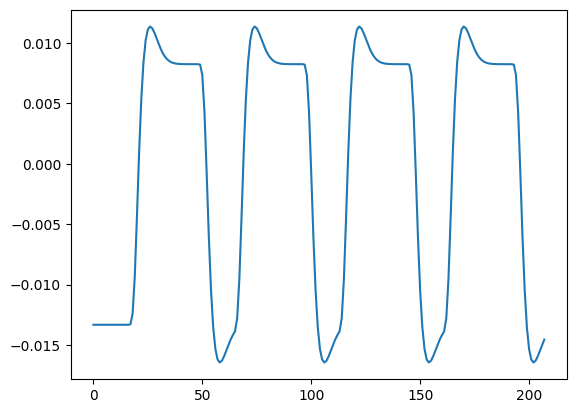

In [18]:
plt.plot(pred_data_all[:,203723])